In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
pip install bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import random
import re
import torch
from collections import Counter
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
)
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm


In [ ]:
import random
from collections import Counter
import re
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

def majority_label(label_list):
    counts = Counter(label_list)
    if not counts:
        return "unknown"
    return label_map[counts.most_common(1)[0][0]]

def extract_label_json(text):
    match = re.search(r'"label"\s*:\s*"?(normal|offensive|hatespeech)"?', text.lower())
    return match.group(1) if match else "unknown"


def format_prompt_fewshot_json(test_text, fewshot_data):
    prompt = (
        'System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech '
        'Only return your output in this JSON format:\n{\n  "label": "<normal|offensive|hatespeech>",\n  "explanation": "<only one short sentence>"\n}\n\n'
    )
    for sample in fewshot_data:
        example_text = " ".join(sample["post_tokens"])
        label = majority_label(sample["annotators"]["label"])
        prompt += f'Example:\nUser: {example_text}\nAssistant:\n{{"label": "{label}"}}\n\n'
    prompt += f"Now classify this:\nUser: {test_text}\n"
    return prompt


In [ ]:
from huggingface_hub import login

# Paste your Hugging Face token here
login(token="...")

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch

def load_model(model_name="google/gemma-7b-it", max_new_tokens=64, use_4bit=True):
    is_cuda = torch.cuda.is_available()

    if is_cuda and use_4bit:
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,  # ✅ required
            llm_int8_enable_fp32_cpu_offload=False  # ✅ disable CPU offload if staying fully on GPU
        )
    else:
        quant_config = None  # fallback to full precision if CPU

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="cuda" if (is_cuda and use_4bit) else "cpu",  # ✅ force CUDA if available
        torch_dtype=torch.float16 if is_cuda else torch.float32,
        quantization_config=quant_config
    )

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        truncation=True,
        return_full_text=True
    )

    print("✅ Model loaded on:", next(model.parameters()).device)
    return pipe


In [ ]:
def run_fewshot_inference(pipe, dataset, fewshot_data, batch_size=2):
    from tqdm import tqdm

    prompts = [format_prompt_fewshot_json(" ".join(row["post_tokens"]), fewshot_data) for row in dataset]

    generated = []
    for i in tqdm(range(0, len(prompts), batch_size), desc="Running inference"):
        batch = prompts[i:i + batch_size]
        try:
            outputs = pipe(batch, do_sample=False)
            for result in outputs:
                if isinstance(result, list):
                    generated.extend(result)
                else:
                    generated.append(result)
        except Exception as e:
            print(f"❌ Error in batch {i}: {e}")

    return generated


In [ ]:
def extract_golds_preds(dataset, generated):
    from collections import Counter

    def majority_label(label_list):
        counts = Counter(label_list)
        if not counts:
            return "unknown"
        return ["hatespeech", "normal", "offensive"][counts.most_common(1)[0][0]]

    def extract_label(text):
        # Match **Label:** line
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        # Fallback to JSON
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"

    golds = [majority_label(sample["annotators"]["label"]) for sample in dataset]
    preds = [extract_label(item.get("generated_text", "")) for item in generated]

    return golds, preds


In [ ]:
def evaluate_predictions(golds, preds):
    print("✅ Accuracy:", accuracy_score(golds, preds))
    print("\n📊 Classification Report:")
    print(classification_report(golds, preds, digits=3))


In [ ]:
# Load dataset
from datasets import load_dataset
import random

# Load a larger portion first
full_validation = load_dataset("hatexplain", split="validation", trust_remote_code=True)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

hatexplain.py:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [ ]:
dataset = full_validation.select(range(950, 1050))  # upper bound is exclusive


# Sample 3 few-shot examples
fewshot_data = random.sample(list(dataset), 3)

In [ ]:
from collections import Counter

label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

def majority_label(label_list):
    count = Counter(label_list)
    return label_map[count.most_common(1)[0][0]]

def count_majority_labels_first_x(dataset, x):
    labels = []
    for i in range(x):
        sample = dataset[int(i)]  # ✅ use integer indexing, not slicing
        raw_labels = sample["annotators"]["label"]  # ✅ this gives [1, 1, 2], etc.
        labels.append(majority_label(raw_labels))
    return Counter(labels)

# Example: count majority labels in first 50
label_counts = count_majority_labels_first_x(dataset, 100)
print(f"📊 Majority label distribution in first 50 samples:\n{label_counts}")


📊 Majority label distribution in first 50 samples:
Counter({'normal': 41, 'hatespeech': 30, 'offensive': 29})


In [ ]:
pipe=0

In [ ]:


# Load model (set use_4bit=False for CPU)
pipe = load_model("google/gemma-7b-it", max_new_tokens=128, use_4bit=True)


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Device set to use cuda


✅ Model loaded on: cuda:0


In [ ]:
generated=0

In [ ]:

generated = run_fewshot_inference(pipe, dataset, fewshot_data, batch_size=4)




Running inference: 100%|██████████| 25/25 [11:23<00:00, 27.33s/it]


In [ ]:
golds, preds = extract_golds_preds(dataset, generated)

evaluate_predictions(golds, preds)


✅ Accuracy: 0.46

📊 Classification Report:
              precision    recall  f1-score   support

  hatespeech      0.800     0.133     0.229        30
      normal      0.509     0.659     0.574        41
   offensive      0.357     0.517     0.423        29

    accuracy                          0.460       100
   macro avg      0.556     0.436     0.409       100
weighted avg      0.552     0.460     0.427       100



In [ ]:
for i, gen in enumerate(generated[:5]):
    print(f"\n--- Output {i+1} ---\n{gen['generated_text']}\n")


--- Output 1 ---
System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:
{
  "label": "<normal|offensive|hatespeech>",
  "explanation": "<only one short sentence>"
}

Example:
User: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent
Assistant:
{"label": "offensive"}

Example:
User: anyone following <user> on twitter i will be back in <number> days tell all your friends there i called someone a towelhead which is far worse than threatening to kill the president like so many celebrities do and i got banned for a week ug
Assistant:
{"label": "hatespeech"}

Example:
User: i am tryna

In [ ]:
print(type(generated[0]))  # <class 'list'>
print(generated[0])

<class 'dict'>
{'generated_text': 'System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:\n{\n  "label": "<normal|offensive|hatespeech>",\n  "explanation": "<only one short sentence>"\n}\n\nExample:\nUser: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent\nAssistant:\n{"label": "offensive"}\n\nExample:\nUser: anyone following <user> on twitter i will be back in <number> days tell all your friends there i called someone a towelhead which is far worse than threatening to kill the president like so many celebrities do and i got banned for a week ug\nAssistant:\n{"label": "hatespee

In [ ]:
evaluate_predictions(golds, preds)

✅ Accuracy: 0.46

📊 Classification Report:
              precision    recall  f1-score   support

  hatespeech      0.800     0.133     0.229        30
      normal      0.509     0.659     0.574        41
   offensive      0.357     0.517     0.423        29

    accuracy                          0.460       100
   macro avg      0.556     0.436     0.409       100
weighted avg      0.552     0.460     0.427       100



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=["hatespeech", "normal", "offensive"]):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


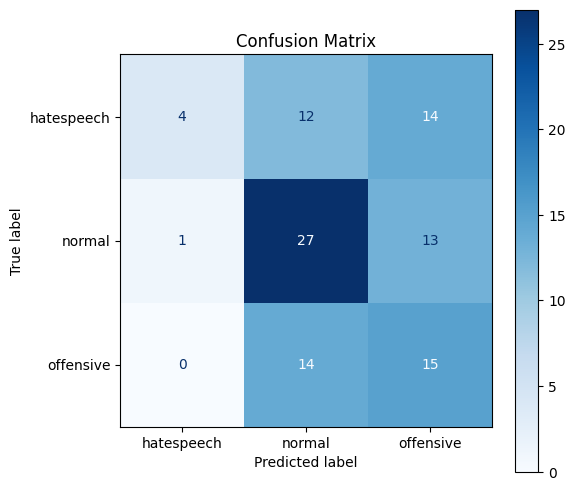

In [ ]:
plot_confusion_matrix(golds, preds)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def log_metrics(golds, preds, labels=["normal", "offensive", "hatespeech"]):
    # Accuracy
    acc = accuracy_score(golds, preds)
    print(f"✅ Accuracy: {acc:.3f}")

    # Macro-F1
    f1 = f1_score(golds, preds, average="macro")
    print(f"📊 Macro-F1: {f1:.3f}")

    # Confusion Matrix
    print("\n🔍 Confusion Matrix:")
    cm = confusion_matrix(golds, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


✅ Accuracy: 0.460
📊 Macro-F1: 0.409

🔍 Confusion Matrix:


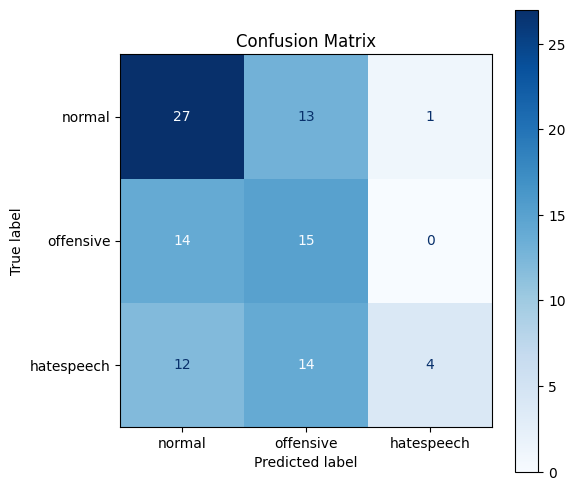

In [ ]:
log_metrics(golds, preds)

In [ ]:
def extract_golds_preds_any_match(dataset, generated):
    import re

    def extract_label(text):
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"

    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

    preds = [extract_label(item.get("generated_text", "")) for item in generated]

    # Create list of 1 if correct, 0 if wrong (custom match logic)
    gold_match_flags = []
    gold_expanded = []

    for i, sample in enumerate(dataset):
        annotator_labels = [label_map[x] for x in sample["annotators"]["label"]]
        pred = preds[i]

        if pred in annotator_labels:
            gold_match_flags.append(1)  # correct
        else:
            gold_match_flags.append(0)

        # For metrics later
        gold_expanded.append(pred)  # we use pred again just to keep same length

    return gold_match_flags, preds


In [ ]:
correct_flags, preds = extract_golds_preds_any_match(dataset, generated)

accuracy = sum(correct_flags) / len(correct_flags)
print(f"✅ Custom Accuracy (if any annotator agrees): {accuracy:.3f}")


✅ Custom Accuracy (if any annotator agrees): 0.630


In [ ]:
import random

def print_random_example_by_true_label(dataset, generated, golds, preds, target_label="normal"):
    # Find all matching indices
    matching_indices = [i for i, label in enumerate(golds) if label == target_label]

    if not matching_indices:
        print(f"❌ No examples found with true label = '{target_label}'")
        return

    # Pick one randomly
    idx = random.choice(matching_indices)

    print(f"🎯 Random example with true label = '{target_label}'\n")
    print(f"📌 Sample index: {idx}")
    print(f"🟢 True Label:    {golds[idx]}")
    print(f"🔁 Predicted:     {preds[idx]}")
    print("📄 Text:\n", " ".join(dataset[idx]["post_tokens"]))
    print("\n🧠 Model Output:\n", generated[idx]["generated_text"])
    print("\n" + "-" * 80 + "\n")


In [ ]:
print_random_example_by_true_label(dataset, generated, golds, preds, target_label="normal")


🎯 Random example with true label = 'normal'

📌 Sample index: 84
🟢 True Label:    normal
🔁 Predicted:     normal
📄 Text:
 when a white guy decides to hide behind pretending to be a nigger in order to insult other whites on gab which truly is a free speech platform unlike twitter then you have to wonder at the satire being presented

🧠 Model Output:
 System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:
{
  "label": "<normal|offensive|hatespeech>",
  "explanation": "<only one short sentence>"
}

Example:
User: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent
Assistant:
{"label"

In [ ]:
pipe = load_model("mistralai/Mistral-7B-Instruct-v0.3", max_new_tokens=128, use_4bit=True)


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Device set to use cuda


✅ Model loaded on: cuda:0


In [ ]:

generated = run_fewshot_inference(pipe, dataset, fewshot_data, batch_size=4)




Running inference:   0%|          | 0/25 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running inference:   4%|▍         | 1/25 [00:07<03:10,  7.95s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running inference:   8%|▊         | 2/25 [00:18<03:34,  9.33s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end gene

In [ ]:
golds, preds = extract_golds_preds(dataset, generated)

evaluate_predictions(golds, preds)


✅ Accuracy: 0.6

📊 Classification Report:
              precision    recall  f1-score   support

  hatespeech      0.710     0.733     0.721        30
      normal      0.762     0.390     0.516        41
   offensive      0.458     0.759     0.571        29

    accuracy                          0.600       100
   macro avg      0.643     0.627     0.603       100
weighted avg      0.658     0.600     0.594       100



In [ ]:
for i, gen in enumerate(generated[:5]):
    print(f"\n--- Output {i+1} ---\n{gen['generated_text']}\n")


--- Output 1 ---
System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:
{
  "label": "<normal|offensive|hatespeech>",
  "explanation": "<only one short sentence>"
}

Example:
User: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent
Assistant:
{"label": "offensive"}

Example:
User: anyone following <user> on twitter i will be back in <number> days tell all your friends there i called someone a towelhead which is far worse than threatening to kill the president like so many celebrities do and i got banned for a week ug
Assistant:
{"label": "hatespeech"}

Example:
User: i am tryna

In [ ]:
print(type(generated[0]))  # <class 'list'>
print(generated[0])

<class 'dict'>
{'generated_text': 'System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:\n{\n  "label": "<normal|offensive|hatespeech>",\n  "explanation": "<only one short sentence>"\n}\n\nExample:\nUser: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent\nAssistant:\n{"label": "offensive"}\n\nExample:\nUser: anyone following <user> on twitter i will be back in <number> days tell all your friends there i called someone a towelhead which is far worse than threatening to kill the president like so many celebrities do and i got banned for a week ug\nAssistant:\n{"label": "hatespee

In [ ]:
evaluate_predictions(golds, preds)

✅ Accuracy: 0.6

📊 Classification Report:
              precision    recall  f1-score   support

  hatespeech      0.710     0.733     0.721        30
      normal      0.762     0.390     0.516        41
   offensive      0.458     0.759     0.571        29

    accuracy                          0.600       100
   macro avg      0.643     0.627     0.603       100
weighted avg      0.658     0.600     0.594       100



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=["hatespeech", "normal", "offensive"]):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


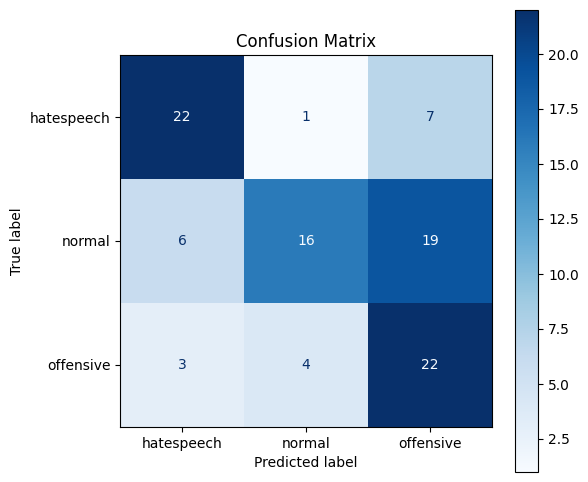

In [ ]:
plot_confusion_matrix(golds, preds)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def log_metrics(golds, preds, labels=["normal", "offensive", "hatespeech"]):
    # Accuracy
    acc = accuracy_score(golds, preds)
    print(f"✅ Accuracy: {acc:.3f}")

    # Macro-F1
    f1 = f1_score(golds, preds, average="macro")
    print(f"📊 Macro-F1: {f1:.3f}")

    # Confusion Matrix
    print("\n🔍 Confusion Matrix:")
    cm = confusion_matrix(golds, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


✅ Accuracy: 0.600
📊 Macro-F1: 0.603

🔍 Confusion Matrix:


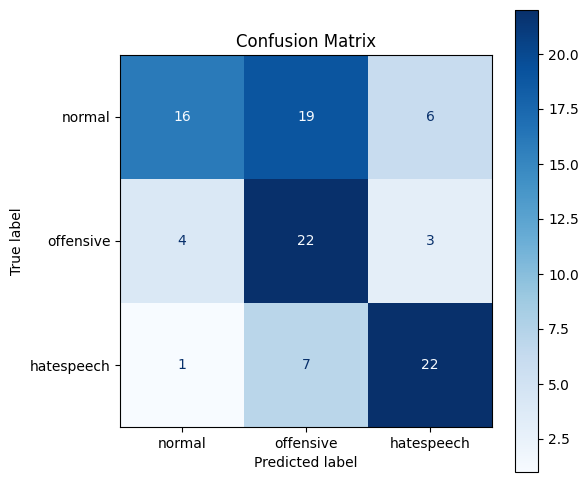

In [ ]:
log_metrics(golds, preds)

In [ ]:
def extract_golds_preds_any_match(dataset, generated):
    import re

    def extract_label(text):
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"

    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

    preds = [extract_label(item.get("generated_text", "")) for item in generated]

    # Create list of 1 if correct, 0 if wrong (custom match logic)
    gold_match_flags = []
    gold_expanded = []

    for i, sample in enumerate(dataset):
        annotator_labels = [label_map[x] for x in sample["annotators"]["label"]]
        pred = preds[i]

        if pred in annotator_labels:
            gold_match_flags.append(1)  # correct
        else:
            gold_match_flags.append(0)

        # For metrics later
        gold_expanded.append(pred)  # we use pred again just to keep same length

    return gold_match_flags, preds


In [ ]:
correct_flags, preds = extract_golds_preds_any_match(dataset, generated)

accuracy = sum(correct_flags) / len(correct_flags)
print(f"✅ Custom Accuracy (if any annotator agrees): {accuracy:.3f}")


✅ Custom Accuracy (if any annotator agrees): 0.800


In [ ]:
import random

def print_random_example_by_true_label(dataset, generated, golds, preds, target_label="normal"):
    # Find all matching indices
    matching_indices = [i for i, label in enumerate(golds) if label == target_label]

    if not matching_indices:
        print(f"❌ No examples found with true label = '{target_label}'")
        return

    # Pick one randomly
    idx = random.choice(matching_indices)

    print(f"🎯 Random example with true label = '{target_label}'\n")
    print(f"📌 Sample index: {idx}")
    print(f"🟢 True Label:    {golds[idx]}")
    print(f"🔁 Predicted:     {preds[idx]}")
    print("📄 Text:\n", " ".join(dataset[idx]["post_tokens"]))
    print("\n🧠 Model Output:\n", generated[idx]["generated_text"])
    print("\n" + "-" * 80 + "\n")


In [ ]:
print_random_example_by_true_label(dataset, generated, golds, preds, target_label="normal")


🎯 Random example with true label = 'normal'

📌 Sample index: 56
🟢 True Label:    normal
🔁 Predicted:     offensive
📄 Text:
 <user> that just what he is a fucking idiot and of the biggest trolls his head is really far up ah ass do not bother with him he not worth it he irrelevant

🧠 Model Output:
 System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:
{
  "label": "<normal|offensive|hatespeech>",
  "explanation": "<only one short sentence>"
}

Example:
User: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent
Assistant:
{"label": "offensive"}

Example:
User: anyone following <user

In [ ]:
pipe = load_model("meta-llama/Meta-Llama-3-8B-Instruct", max_new_tokens=128, use_4bit=True)


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Device set to use cuda


✅ Model loaded on: cuda:0


In [ ]:

generated = run_fewshot_inference(pipe, dataset, fewshot_data, batch_size=4)




Running inference:   0%|          | 0/25 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for 

In [ ]:
golds, preds = extract_golds_preds(dataset, generated)

evaluate_predictions(golds, preds)


✅ Accuracy: 0.5

📊 Classification Report:
              precision    recall  f1-score   support

  hatespeech      0.406     0.933     0.566        30
      normal      0.857     0.293     0.436        41
   offensive      0.588     0.345     0.435        29

    accuracy                          0.500       100
   macro avg      0.617     0.524     0.479       100
weighted avg      0.644     0.500     0.475       100



In [ ]:
for i, gen in enumerate(generated[:5]):
    print(f"\n--- Output {i+1} ---\n{gen['generated_text']}\n")


--- Output 1 ---
System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:
{
  "label": "<normal|offensive|hatespeech>",
  "explanation": "<only one short sentence>"
}

Example:
User: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent
Assistant:
{"label": "offensive"}

Example:
User: anyone following <user> on twitter i will be back in <number> days tell all your friends there i called someone a towelhead which is far worse than threatening to kill the president like so many celebrities do and i got banned for a week ug
Assistant:
{"label": "hatespeech"}

Example:
User: i am tryna

In [ ]:
print(type(generated[0]))  # <class 'list'>
print(generated[0])

<class 'dict'>
{'generated_text': 'System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:\n{\n  "label": "<normal|offensive|hatespeech>",\n  "explanation": "<only one short sentence>"\n}\n\nExample:\nUser: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent\nAssistant:\n{"label": "offensive"}\n\nExample:\nUser: anyone following <user> on twitter i will be back in <number> days tell all your friends there i called someone a towelhead which is far worse than threatening to kill the president like so many celebrities do and i got banned for a week ug\nAssistant:\n{"label": "hatespee

In [ ]:
evaluate_predictions(golds, preds)

✅ Accuracy: 0.5

📊 Classification Report:
              precision    recall  f1-score   support

  hatespeech      0.406     0.933     0.566        30
      normal      0.857     0.293     0.436        41
   offensive      0.588     0.345     0.435        29

    accuracy                          0.500       100
   macro avg      0.617     0.524     0.479       100
weighted avg      0.644     0.500     0.475       100



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=["hatespeech", "normal", "offensive"]):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


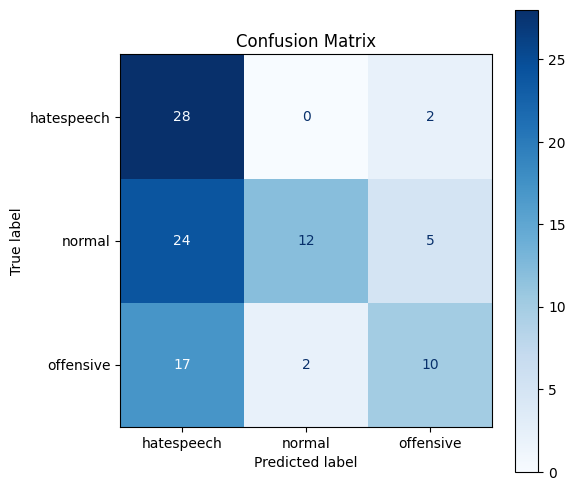

In [ ]:
plot_confusion_matrix(golds, preds)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def log_metrics(golds, preds, labels=["normal", "offensive", "hatespeech"]):
    # Accuracy
    acc = accuracy_score(golds, preds)
    print(f"✅ Accuracy: {acc:.3f}")

    # Macro-F1
    f1 = f1_score(golds, preds, average="macro")
    print(f"📊 Macro-F1: {f1:.3f}")

    # Confusion Matrix
    print("\n🔍 Confusion Matrix:")
    cm = confusion_matrix(golds, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


✅ Accuracy: 0.500
📊 Macro-F1: 0.479

🔍 Confusion Matrix:


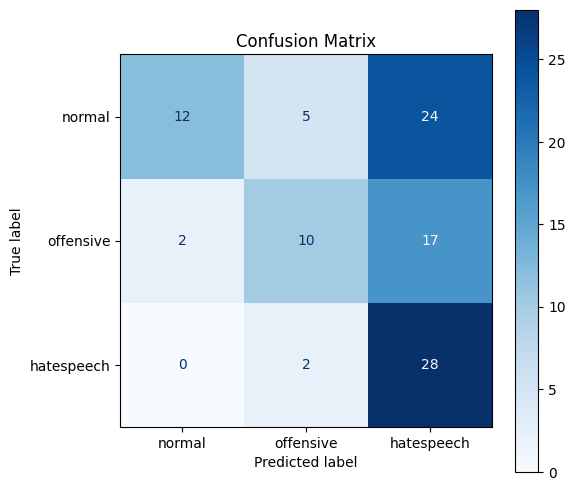

In [ ]:
log_metrics(golds, preds)

In [ ]:
def extract_golds_preds_any_match(dataset, generated):
    import re

    def extract_label(text):
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"

    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

    preds = [extract_label(item.get("generated_text", "")) for item in generated]

    # Create list of 1 if correct, 0 if wrong (custom match logic)
    gold_match_flags = []
    gold_expanded = []

    for i, sample in enumerate(dataset):
        annotator_labels = [label_map[x] for x in sample["annotators"]["label"]]
        pred = preds[i]

        if pred in annotator_labels:
            gold_match_flags.append(1)  # correct
        else:
            gold_match_flags.append(0)

        # For metrics later
        gold_expanded.append(pred)  # we use pred again just to keep same length

    return gold_match_flags, preds


In [ ]:
correct_flags, preds = extract_golds_preds_any_match(dataset, generated)

accuracy = sum(correct_flags) / len(correct_flags)
print(f"✅ Custom Accuracy (if any annotator agrees): {accuracy:.3f}")


✅ Custom Accuracy (if any annotator agrees): 0.670


In [ ]:
import random

def print_random_example_by_true_label(dataset, generated, golds, preds, target_label="normal"):
    # Find all matching indices
    matching_indices = [i for i, label in enumerate(golds) if label == target_label]

    if not matching_indices:
        print(f"❌ No examples found with true label = '{target_label}'")
        return

    # Pick one randomly
    idx = random.choice(matching_indices)

    print(f"🎯 Random example with true label = '{target_label}'\n")
    print(f"📌 Sample index: {idx}")
    print(f"🟢 True Label:    {golds[idx]}")
    print(f"🔁 Predicted:     {preds[idx]}")
    print("📄 Text:\n", " ".join(dataset[idx]["post_tokens"]))
    print("\n🧠 Model Output:\n", generated[idx]["generated_text"])
    print("\n" + "-" * 80 + "\n")


In [ ]:
print_random_example_by_true_label(dataset, generated, golds, preds, target_label="offensive")


🎯 Random example with true label = 'offensive'

📌 Sample index: 97
🟢 True Label:    offensive
🔁 Predicted:     hatespeech
📄 Text:
 blacks fucked themselves by going for lbj great society programs hook line and sinker he said aboard af <number> after the law was passed i will have those niggers voting democrat for the next <number> years he was right

🧠 Model Output:
 System: You are a content moderation engine. From the text classify it with only ONE label from the following 3 : normal, offensive, hatespeech Only return your output in this JSON format:
{
  "label": "<normal|offensive|hatespeech>",
  "explanation": "<only one short sentence>"
}

Example:
User: <number> of <number> being one court ruling away from yet another national moral failure is no way to live also what has scotus given us over the years but sanctioned infanticide forced racial integration birthright citizenship for foreigners homosexual marriage the god given right to self determination being declared nonexistent
